In [25]:
import math, torch, numpy as np
from torch import nn
from torchrl.modules.tensordict_module.rnn import LSTMCell
from torch.func import vmap
import torch.nn.functional as F

# ---------------- utils --------------------------------------------
def remap(t, range=(0, 100), scale=None):
    return t  # no remap for now
    if scale is None:
        scale = range[1] - range[0]
    t = t / range[1]
    return (t * 2 - 1)*scale

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# ---------------- lattice & lookup ---------------------------------
M_MAX, P_MAX = 8, 8
N_STATES = (M_MAX + 1) * (P_MAX + 1)

# ---------------- CME parameters -----------------------------------
class GeneExpressionCRN:
    def __init__(self, k_r=2, k_p=2, g_r=2, g_p=2):
        self.k_r, self.k_p, self.g_r, self.g_p = k_r, k_p, g_r, g_p

# ---------------- positional encoding ------------------------------
class PosEnc(nn.Module):
    def __init__(self, n_freq=6):
        super().__init__()
        self.register_buffer("f", 2 ** torch.arange(n_freq).float() * math.pi)
    def forward(self, t):
        t = t[..., None]  # [B,1]
        return torch.cat([torch.sin(t * self.f), torch.cos(t * self.f)], dim=-1)

# ---------------- autoregressive pθ(m,p | t) -----------------------
class ARProbNet(nn.Module):
    def __init__(self, hidden=128, n_freq=6, tau=1.0, batch_size=256):
        super().__init__()
        self.tau = torch.nn.Parameter(torch.tensor(tau), requires_grad=False)
        self.batch_size = batch_size
        self.device = DEVICE

        self.pe = PosEnc(n_freq)
        self.time_emb = nn.Sequential(
            nn.Linear(2 * n_freq, hidden),
            nn.SiLU(),
            nn.Linear(hidden, hidden),
        )
        self.lstm = LSTMCell(2 * n_freq, hidden)

        self.m_proj = nn.Linear(M_MAX + 1, 2 * n_freq)

        self.head_m = nn.Linear(hidden, M_MAX + 1)
        self.head_p = nn.Linear(hidden, P_MAX + 1)

        self.register_buffer("m_norm", torch.linspace(0, 1, M_MAX + 1))
        self.register_buffer("p_norm", torch.linspace(0, 1, P_MAX + 1))
        self.register_buffer("m_grid", torch.arange(M_MAX + 1, device=DEVICE).float())
        self.register_buffer("p_grid", torch.arange(P_MAX + 1, device=DEVICE).float())

        # you must set net.t_max externally

    def forward(self, t):
        # sampling path: returns soft m as well
        x0 = remap(t)
        pe_t = self.pe(x0)
        h = self.time_emb(pe_t); c = h.clone()

        # ---- first step: m ----
        h, c = self.lstm(pe_t, (h, c))
        logits_m = self.head_m(h)
        dist_m = torch.distributions.RelaxedOneHotCategorical(temperature=self.tau, logits=logits_m)
        oh_m_soft = dist_m.rsample()  # relaxed
        oh_m_hard = F.one_hot(oh_m_soft.argmax(dim=-1), logits_m.size(-1)).float()
        oh_m = oh_m_hard + (oh_m_soft - oh_m_soft.detach())
        m_scalar = (oh_m_hard * self.m_grid).sum(-1, keepdim=True)

        # ---- second step: p | m ----
        m_cond = self.m_proj(oh_m_soft)
        cond_p = pe_t + m_cond
        h, c = self.lstm(cond_p, (h, c))
        logits_p = self.head_p(h)
        dist_p = torch.distributions.RelaxedOneHotCategorical(temperature=self.tau, logits=logits_p)
        oh_p_soft = dist_p.rsample()
        oh_p_hard = F.one_hot(oh_p_soft.argmax(dim=-1), logits_p.size(-1)).float()
        oh_p = oh_p_hard + (oh_p_soft - oh_p_soft.detach())
        p_scalar = (oh_p_hard * self.p_grid).sum(-1, keepdim=True)

        entropy_m = torch.distributions.Categorical(logits=logits_m).entropy()
        entropy_p = torch.distributions.Categorical(logits=logits_p).entropy()

        # actual probability 
        # p(m,p | t) = p(m | t) * p(p | m, t)
        log_p_m = torch.log_softmax(logits_m, dim=-1)
        log_p_m_chosen = (log_p_m * oh_m_hard).sum(-1)

        log_p_p_given_m = torch.log_softmax(logits_p, dim=-1)
        log_p_p_chosen = (log_p_p_given_m * oh_p_hard).sum(-1)

        log_total = log_p_m_chosen + log_p_p_chosen
        total_prob = log_total.exp()

        return m_scalar, p_scalar, oh_m, oh_p, entropy_m, entropy_p, oh_m_soft, total_prob

    def get_probability(self, oh_m, oh_p, oh_m_soft, t):
        # evaluation path (needs soft m for conditioning)
        x0 = remap(t)
        pe_t = self.pe(x0)
        h = self.time_emb(pe_t); c = h.clone()

        # p(m | t)
        h, c = self.lstm(pe_t, (h, c))
        logits_m = self.head_m(h)
        p_m = torch.softmax(logits_m, dim=-1)
        p_m_chosen = (p_m * oh_m).sum(-1)

        # p(p | m, t)
        m_cond = self.m_proj(oh_m_soft)
        cond_p = pe_t + m_cond
        h, c = self.lstm(cond_p, (h, c))
        logits_p = self.head_p(h)
        p_p_m = torch.softmax(logits_p, dim=-1)
        p_p_chosen = (p_p_m * oh_p).sum(-1)

        return p_m_chosen * p_p_chosen

# ---------------- helpers ------------------------------------------
def idx_to_onehot(idx, num_classes):
    return F.one_hot(idx.clamp(0, num_classes - 1).long(), num_classes).float()

@torch.no_grad()
def _all_states_onehot():
    m_all = torch.arange(M_MAX + 1, device=DEVICE)
    p_all = torch.arange(P_MAX + 1, device=DEVICE)
    m_mesh = m_all.repeat_interleave(P_MAX + 1)
    p_mesh = p_all.repeat(M_MAX + 1)
    oh_m_all = F.one_hot(m_mesh, M_MAX + 1).float()
    oh_p_all = F.one_hot(p_mesh, P_MAX + 1).float()
    return oh_m_all, oh_p_all, m_mesh, p_mesh

# def sample_states_mixture(net, t_star, K=256, alpha=0.5, eps=1e-12):
#     # uniform
#     m_u = torch.randint(0, M_MAX + 1, (K,), device=DEVICE)
#     p_u = torch.randint(0, P_MAX + 1, (K,), device=DEVICE)

#     # model-based over full lattice
#     oh_m_all, oh_p_all, m_mesh, p_mesh = _all_states_onehot()
#     with torch.no_grad():
#         probs_all = net.get_probability(oh_m_all, oh_p_all, oh_m_all, t_star.expand(N_STATES)).clamp_min(eps)
#         probs_all = probs_all / probs_all.sum()
#         idx_imp = torch.multinomial(probs_all, K, replacement=True)
#         m_imp = m_mesh[idx_imp]; p_imp = p_mesh[idx_imp]

#     use_imp = (torch.rand(K, device=DEVICE) < alpha)
#     m_s = torch.where(use_imp, m_imp, m_u)
#     p_s = torch.where(use_imp, p_imp, p_u)

#     oh_m_s = F.one_hot(m_s, M_MAX + 1).float()
#     oh_p_s = F.one_hot(p_s, P_MAX + 1).float()
#     return m_s, p_s, oh_m_s, oh_p_s

# ---------------- physics losses (modular) -------------------------
# def loss_importance_residual(net, crn, t_star, *, K=256, alpha=0.5, clamp=1e-4, huber_delta=1.0):
#     m_s, p_s, oh_m_s, oh_p_s = sample_states_mixture(net, t_star, K=K, alpha=alpha)

#     t_u = t_star.expand(K)
#     # use hard-one-hot also as soft conditioner for exact state eval
#     p_u = net.get_probability(oh_m_s, oh_p_s, oh_m_s, t_u)  # [K]
#     dpdt_u = torch.autograd.grad(p_u, t_star, grad_outputs=torch.ones_like(p_u), create_graph=True)[0]

#     # neighbours
#     m_u = m_s.float(); p_u_int = p_s.float()
#     m_u_n = torch.stack([m_u - 1, m_u + 1, m_u, m_u], dim=-1).clamp(0, M_MAX)
#     p_u_n = torch.stack([p_u_int, p_u_int, p_u_int - 1, p_u_int + 1], dim=-1).clamp(0, P_MAX)
#     oh_m_n = F.one_hot(m_u_n.long(), M_MAX + 1).float()
#     oh_p_n = F.one_hot(p_u_n.long(), P_MAX + 1).float()
#     t_u_rep = t_star.expand(K, 4)

#     p_neigh = net.get_probability(
#         oh_m_n.reshape(-1, M_MAX + 1),
#         oh_p_n.reshape(-1, P_MAX + 1),
#         oh_m_n.reshape(-1, M_MAX + 1),  # soft = hard here
#         t_u_rep.reshape(-1),
#     ).reshape(K, 4)

#     k_r = torch.as_tensor(crn.k_r, device=DEVICE, dtype=torch.float32)
#     k_p = torch.as_tensor(crn.k_p, device=DEVICE, dtype=torch.float32)
#     g_r = torch.as_tensor(crn.g_r, device=DEVICE, dtype=torch.float32)
#     g_p = torch.as_tensor(crn.g_p, device=DEVICE, dtype=torch.float32)

#     inflow = (
#         k_r * p_neigh[:, 0]
#         + g_r * (m_u + 1) * p_neigh[:, 1]
#         + k_p * m_u * p_neigh[:, 2]
#         + g_p * (p_u_int + 1) * p_neigh[:, 3]
#     )
#     flux_out = (g_r * m_u + k_r + g_p * p_u_int + k_p * m_u) * p_u
#     Ap_u = inflow - flux_out

#     # robust relative residual
#     num = dpdt_u - Ap_u
#     abs_num = num.abs()
#     huber = torch.where(abs_num <= huber_delta, 0.5 * num * num, huber_delta * (abs_num - 0.5 * huber_delta))
#     denom = p_u.detach().clamp_min(clamp)
#     return (huber / (denom * denom)).mean()

# @torch.no_grad()
def _ap_from_samples(net, crn, m_int, p_int, t, neigh, oh_m, oh_p, oh_m_soft):
    N, B = m_int.shape
    k_r = torch.as_tensor(crn.k_r, device=DEVICE, dtype=torch.float32)
    k_p = torch.as_tensor(crn.k_p, device=DEVICE, dtype=torch.float32)
    g_r = torch.as_tensor(crn.g_r, device=DEVICE, dtype=torch.float32)
    g_p = torch.as_tensor(crn.g_p, device=DEVICE, dtype=torch.float32)

    m_n = m_int.unsqueeze(-1) + neigh[..., 0]
    p_n = p_int.unsqueeze(-1) + neigh[..., 1]
    valid = (m_n >= 0) & (m_n <= M_MAX) & (p_n >= 0) & (p_n <= P_MAX)
    m_n_c = m_n.clamp(0, M_MAX)
    p_n_c = p_n.clamp(0, P_MAX)

    m_flat = m_n_c.reshape(N, -1)
    p_flat = p_n_c.reshape(N, -1)
    t_flat = t.reshape(N, B, 1).repeat(1, 1, 4).reshape(N, 4 * B)

    oh_m_flat = vmap(lambda x: idx_to_onehot(x, M_MAX + 1), (0))(m_flat)
    oh_p_flat = vmap(lambda x: idx_to_onehot(x, P_MAX + 1), (0))(p_flat)

    prob_flat = vmap(
        lambda ohm, ohp, tt: net.get_probability(ohm, ohp, ohm, tt),  # soft = hard for neighbors
        in_dims=(0, 0, 0),
    )(oh_m_flat, oh_p_flat, t_flat)

    prob_flat = torch.where(valid.reshape(N, -1), prob_flat, torch.zeros_like(prob_flat))
    prob_neigh = prob_flat.view(N, B, 4)

    m_prev, m_next, p_prev, p_next = prob_neigh[..., 0], prob_neigh[..., 1], prob_neigh[..., 2], prob_neigh[..., 3]

    flux_m_prev = m_prev * k_r
    flux_m_next = m_next * g_r * m_n_c[..., 1]
    flux_p_prev = p_prev * k_p * m_n_c[..., 2]
    flux_p_next = p_next * g_p * p_n_c[..., 3]
    inflow = flux_m_prev + flux_m_next + flux_p_prev + flux_p_next

    flux_to_m_prev = g_r * m_int.float()
    flux_to_m_next = k_r
    flux_to_p_prev = g_p * p_int.float()
    flux_to_p_next = k_p * m_int.float()

    oh_m_cur = vmap(lambda x: idx_to_onehot(x, M_MAX + 1), (0))(m_int)   # [N,B,M+1]
    oh_p_cur = vmap(lambda x: idx_to_onehot(x, P_MAX + 1), (0))(p_int)   # [N,B,P+1]

    current_p = vmap(
        lambda ohm, ohp, tt: net.get_probability(ohm, ohp, ohm, tt),     # soft=hard
        (0, 0, 0),
    )(oh_m_cur, oh_p_cur, t)

    outflow = (flux_to_m_prev + flux_to_m_next + flux_to_p_prev + flux_to_p_next) * current_p
    return inflow - outflow

def elementwise_rl_residual(dpdt, current_p, Ap_val_detached, *, eps=1e-3):
    num = (dpdt - Ap_val_detached)
    denom = current_p.detach().clamp_min(eps)
    return (num / denom)**2  # [N,B]

def loss_reinforce(current_p, residual, clip=5.0, log_min=-20.0):
    logP = (current_p + 1e-9).log().clamp(min=log_min)
    residual = residual.detach()  # detach to avoid backprop through the residual
    adv = residual - residual.mean()
    return (adv * logP).mean()

@torch.no_grad()
def _p_tplus(net, oh_m, oh_p, oh_m_soft, t, delta_t):
    return vmap(lambda ohm, ohp, ohms, tt: net.get_probability(ohm, ohp, ohms, tt + delta_t), (0, 0, 0, 0))(
        oh_m, oh_p, oh_m_soft, t
    ).clamp_min(1e-9)

def loss_temporal_consistency(net, oh_m, oh_p, oh_m_soft, t, current_p, Ap_val_detached, delta_t):
    p_tplus = _p_tplus(net, oh_m, oh_p, oh_m_soft, t, delta_t)  # teacher
    return ((p_tplus - (current_p + delta_t * Ap_val_detached)) ** 2).mean()

def prob_mp(net, t_vec, m_vec, p_vec):
    oh_m = F.one_hot(m_vec.clamp(0, M_MAX).long(), M_MAX+1).float()
    oh_p = F.one_hot(p_vec.clamp(0, P_MAX).long(), P_MAX+1).float()
    return net.get_probability(oh_m, oh_p, oh_m, t_vec)

def loss_ic(net):
     # initial condition at t=0: delta at (0,0)
    K0 = 512
    t0 = torch.zeros(K0, device=DEVICE)
    m0 = torch.randint(0, M_MAX+1, (K0,), device=DEVICE)
    p0 = torch.randint(0, P_MAX+1, (K0,), device=DEVICE)
    prob0 = prob_mp(net, t0, m0, p0)
    target0 = ((m0 == 0) & (p0 == 0)).float()
    ic_loss = F.mse_loss(prob0, target0)
    return ic_loss

def loss_entropy(entropy_m, entropy_p):
    return -(entropy_m + entropy_p).mean()

@torch.no_grad()
def mass_at(net, t_scalar):
    oh_m_all, oh_p_all, _, _ = _all_states_onehot()
    t_vec = torch.full((N_STATES,), float(t_scalar), device=DEVICE)
    p_all = net.get_probability(oh_m_all, oh_p_all, oh_m_all, t_vec).clamp_min(0)
    return p_all.sum().item()

# ---------------- training loop ------------------------------------
def train(crn, net, *, steps=20000, batch_time=256, batch_size=512, lr=1e-3, t_max=1.0, report=400, loss_aggregator=None):
    opt = torch.optim.Adam(net.parameters(), lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=steps, eta_min=1e-6)
    net.t_max = t_max

    neigh = torch.tensor([[-1, 0], [1, 0], [0, -1], [0, 1]], device=DEVICE)
    opt.zero_grad()

    for step in range(1, steps + 1):
        N = batch_size; B = batch_time
        # if step < 100:      t_max_curr = t_max * 0.30
        # elif step < 200:    t_max_curr = t_max * 0.60
        # else:                t_max_curr = t_max
        t_max_curr = t_max  # for now, no warmup

        t = torch.linspace(0, t_max_curr, batch_time, device=DEVICE, requires_grad=True)
        t_expanded = t.unsqueeze(0).expand(N, -1).clone().requires_grad_()

        # sampling pass
        m_idx, p_idx, oh_m, oh_p, entropy_m, entropy_p, oh_m_soft = vmap(
            lambda _, tt: net(tt), (0, 0), randomness="different"
        )(torch.zeros(N), t_expanded)
        p_idx = p_idx.squeeze(-1); m_idx = m_idx.squeeze(-1)

        oh_m_hard = F.one_hot(m_idx.long(), M_MAX+1).float()
        oh_p_hard = F.one_hot(p_idx.long(), P_MAX+1).float()

        current_p = vmap(
            lambda ohm, ohp, tt: net.get_probability(ohm, ohp, ohm, tt),
            (0, 0, 0), randomness="different"
        )(oh_m_hard, oh_p_hard, t_expanded)

        dpdt = torch.autograd.grad(outputs=current_p, inputs=t_expanded, grad_outputs=torch.ones_like(current_p), create_graph=True)[0]

        with torch.no_grad():
            Ap_val = _ap_from_samples(net, crn, m_idx, p_idx, t_expanded, neigh, oh_m, oh_p, oh_m_soft)

        # with torch.no_grad():
        #     rmse = (dpdt - Ap_val).pow(2).mean().sqrt().item()
        #     d_mean = dpdt.abs().mean().item()
        #     a_mean = Ap_val.abs().mean().item()
        # print(f"  rmse||dpdt-Ap||={rmse:.3e}  |dpdt|={d_mean:.3e}  |Ap|={a_mean:.3e}")

        relative_sq_err_elem = elementwise_rl_residual(dpdt, current_p, Ap_val)

        rl_res = elementwise_rl_residual(dpdt, current_p, Ap_val).mean()
        rl_pg = loss_reinforce(current_p, relative_sq_err_elem)

        # importance residual (optional; off by default in your config)
        # t_star = t[t.size(0) // 2].detach().clone().requires_grad_(True)
        # alpha = 0.1 + 0.7 * min(1.0, (step - 1000) / 6000.0) if step > 1000 else 0.1
        # imp_loss = loss_importance_residual(net, crn, t_star, K=256, alpha=alpha)

        ic = loss_ic(net)
        ent = loss_entropy(entropy_m, entropy_p)

        losses = [rl_res, rl_pg, ic, ent]  # add imp_loss if you want it active
        # loss_aggregator.step(losses, opt)

        loss = loss_aggregator(torch.stack(losses))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), max_norm=1.0)
        opt.step()

        # warmup
        warmup_steps = 100
        if step < warmup_steps:
            lr_scale = (step + 1) / warmup_steps
            for g in opt.param_groups:
                g["lr"] = lr * lr_scale

        if scheduler is not None:
            scheduler.step()

        if step >= 200 and step % 200 == 0:
            net.tau.mul_(0.95).clamp_(min=0.5)

        opt.zero_grad()

        if step % report == 0 or step == 1:
            print(
                f"step {step:6d} | loss {loss.item():.3e} | rl {rl_res.item():.3e} | pg {rl_pg.item():.3e} "
                f"| ic {ic:.3e} | ent {ent:.3e}"# | imp {imp_loss:.3e}"
            )
            with torch.no_grad():
                m0 = mass_at(net, 0.0)
                m_mid = mass_at(net, 0.5 * t_max_curr)
                print(f"  mass@0={m0:.3f} mass@mid={m_mid:.3f}  τ={net.tau.item():.3f}")

# ---------------- run demo -----------------------------------------
from LossAggregators import IVOLossAggregator

crn  = GeneExpressionCRN(k_r=4, k_p=4, g_r=2, g_p=2)
net = ARProbNet(hidden=64, tau=5.0).to(DEVICE)

loss_aggregator = IVOLossAggregator(
    net,
    ["RL", "PG", "IC", "ENT"],
    lambda_lr=0.5,
    max_weight_per_loss={"RL": 1.0, "PG": 1., "IC": 1., "ENT": 1.0},
)

try:
    train(
        crn,
        net,
        steps=20000,
        lr=1e-4,
        batch_time=100,
        batch_size=100,
        t_max=1.5,
        report=100,
        loss_aggregator=loss_aggregator,
    )
except KeyboardInterrupt:
    print("Interrupted.")


ValueError: too many values to unpack (expected 7)

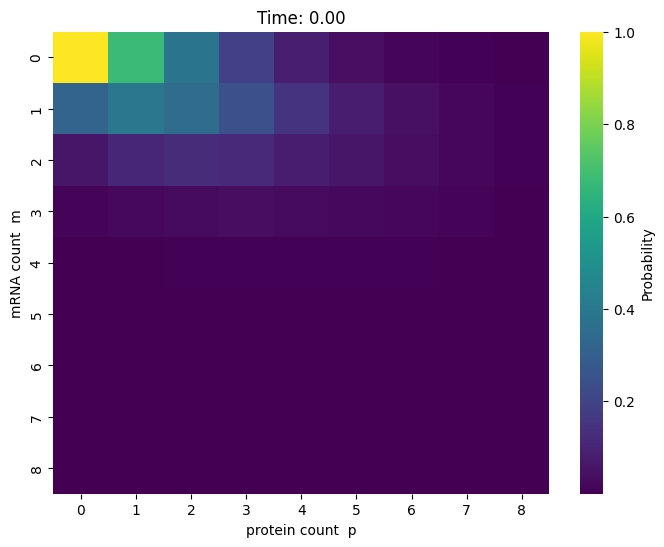

In [ ]:
# ------------------------------------------------------------
# 6.  Single helper that can create *or* update a heat-map
# ------------------------------------------------------------
@torch.no_grad()
def plot_heatmap(net, t, ax=None, hm=None, title=None, normalize="max"):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import inspect

    # Ensure t is scalar tensor on DEVICE
    if isinstance(t, (float, int)):
        t_val = torch.tensor(float(t), device=DEVICE)
    elif isinstance(t, torch.Tensor) and t.numel() == 1:
        t_val = t.flatten()[0].to(DEVICE)
    else:
        raise ValueError("t must be a scalar or length-1 tensor.")

    # Vectorized (m,p) grid → one-hots
    m_grid = torch.arange(M_MAX + 1, device=DEVICE)
    p_grid = torch.arange(P_MAX + 1, device=DEVICE)
    M, P = torch.meshgrid(m_grid, p_grid, indexing="ij")
    oh_m = idx_to_onehot(M.flatten(), M_MAX + 1)  # [N, M+1]
    oh_p = idx_to_onehot(P.flatten(), P_MAX + 1)  # [N, P+1]
    t_vec = t_val.expand(oh_m.shape[0])

    # For the new API, use hard one-hot as "soft" conditioning too
    def _eval_probs(oh_m_, oh_p_, t_):
        # Try new signature: (oh_m, oh_p, oh_m_soft, t)
        try:
            return net.get_probability(oh_m_, oh_p_, oh_m_, t_)
        except TypeError:
            # Fallback to old signature: (oh_m, oh_p, t)
            return net.get_probability(oh_m_, oh_p_, t_)

    prob = _eval_probs(oh_m, oh_p, t_vec)  # [N]
    probs = prob.clamp_min(0).detach().cpu().numpy().reshape(M_MAX + 1, P_MAX + 1)

    # Optional normalization for visualization
    if normalize == "max":
        m = probs.max()
        if m > 0:
            probs = probs / m
    elif normalize == "sum":
        s = probs.sum()
        if s > 0:
            probs = probs / s
    # else: raw scale

    if hm is None or ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
        hm = sns.heatmap(
            probs,
            cmap="viridis",
            cbar_kws={'label': 'Probability'},
            ax=ax, annot=False
        )
        ax.set_xlabel("protein count  p")
        ax.set_ylabel("mRNA count  m")
    else:
        # Robust update
        hm.collections[0].set_array(probs.ravel())
        hm.collections[0].autoscale()  # keep colorbar sane if not normalized
        hm.figure.canvas.draw_idle()

    if title is not None:
        ax.set_title(title)
    return ax, hm


# ------------------------------------------------------------
# updated animate_heatmap – returns the animation object
# ------------------------------------------------------------
import matplotlib.animation as animation
import matplotlib.pyplot as plt

def animate_heatmap(net, t_max=10.0, num_frames=50, normalize="max"):
    # first frame
    t0 = torch.tensor(0.0, device=DEVICE)
    ax, hm = plot_heatmap(net, t0, title="Time: 0.00", normalize=normalize)

    def update(frame):
        t_val = frame * t_max / max(1, (num_frames - 1))
        t_tensor = torch.tensor(t_val, device=DEVICE)
        plot_heatmap(
            net, t_tensor, ax=ax, hm=hm,
            title=f"Time: {t_val:.2f}", normalize=normalize
        )
        return hm.collections

    ani = animation.FuncAnimation(
        hm.figure, update,
        frames=num_frames, blit=False, repeat=True
    )
    return ani


# ------------------------------------------------------------
# Usage after training:
# ------------------------------------------------------------
ani = animate_heatmap(net, t_max=1.5, num_frames=50)
# save as GIF 
ani.save("gene_expression_softmax.gif", writer='pillow', fps=10)


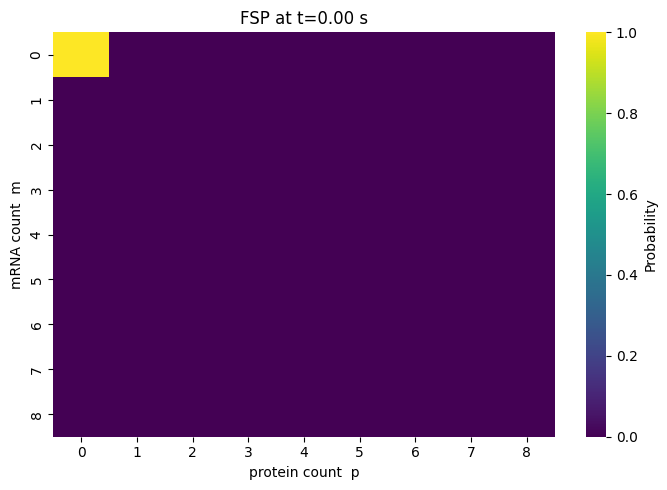

animation saved ➜ gene_expression_fsp.gif


In [ ]:
import numpy as np
import scipy.sparse as sp
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------------------------------------------
# 1. Enumerate lattice states and make {state → index} map
# ------------------------------------------------------------------
states = [(m, p) for m in range(M_MAX + 1) for p in range(P_MAX + 1)]
idx_of = {s: i for i, s in enumerate(states)}
N = len(states)

# ------------------------------------------------------------------
# 2. Build sparse generator matrix A  (dp/dt = A p)
# ------------------------------------------------------------------
def build_generator(crn):
    rows, cols, data = [], [], []

    k_r, k_p, g_r, g_p = crn.k_r, crn.k_p, crn.g_r, crn.g_p
    for (m, p), i in idx_of.items():
        # out-rates
        out_rate = k_r + k_p + g_r + g_p
        rows.append(i); cols.append(i); data.append(-out_rate)

        # in-rates
        if m > 0:            # 0 → M   transcription
            j = idx_of[(m - 1, p)]
            rows.append(i); cols.append(j); data.append(k_r)
        if p > 0:            # translation
            j = idx_of[(m, p - 1)]
            rows.append(i); cols.append(j); data.append(k_p)
        if m < M_MAX:        # mRNA degradation
            j = idx_of[(m + 1, p)]
            rows.append(i); cols.append(j); data.append(g_r)
        if p < P_MAX:        # protein degradation
            j = idx_of[(m, p + 1)]
            rows.append(i); cols.append(j); data.append(g_p)

    A = sp.csr_matrix((data, (rows, cols)), shape=(N, N), dtype=float)
    return A

A = build_generator(GeneExpressionCRN())   # reuse later

# ------------------------------------------------------------------
# 3. FSP ODE rhs  (vectorised)
# ------------------------------------------------------------------
def fsp_ode(t, y, A):
    return A.dot(y)

# ------------------------------------------------------------------
# 4. Solve
# ------------------------------------------------------------------
def solve_fsp(crn, t_span=(0, 10), y0=None, steps=100):
    if y0 is None:
        y0 = np.zeros(N); 
        
        for i in range(1):
            y0[idx_of[(i, i)]] = 1 / 1

    t_eval = np.linspace(t_span[0], t_span[1], steps)
    sol = solve_ivp(
        fsp_ode, t_span, y0,
        args=(build_generator(crn),),
        t_eval=t_eval, rtol=1e-6, atol=1e-9
    )
    return sol.t, sol.y          # y shape (N, len(t_eval))

import numpy as np, matplotlib.pyplot as plt, seaborn as sns
import matplotlib.animation as animation

# ------------------------------------------------------------------
# 5.  Heat-map helper (stand-alone *or* hosted)
# ------------------------------------------------------------------
def plot_fsp_heat(y_flat, *, ax=None, annotate=True, title=None, normalize=None):
    """
    y_flat   : 1-D numpy array of size N_STATES
    normalize: 'max', 'sum', or None
    ax       : optional matplotlib axis; if None a new fig/ax is made
    returns  : (ax, im, txts) where im is the QuadMesh and txts a list of
               annotation Text objects (possibly empty).
    """
    grid = y_flat.reshape(M_MAX + 1, P_MAX + 1)

    # Optional normalization
    if normalize == "max":
        m = grid.max()
        if m > 0:
            grid = grid / m
    elif normalize == "sum":
        s = grid.sum()
        if s > 0:
            grid = grid / s

    own_fig = ax is None
    if own_fig:
        fig, ax = plt.subplots(figsize=(7, 5))

    im = sns.heatmap(
        grid, ax=ax, cmap="viridis",
        cbar_kws={'label': 'Probability'}, annot=False
    )

    txts = []
    if annotate:
        for (i, j), val in np.ndenumerate(grid):
            txts.append(
                ax.text(j + 0.5, i + 0.5, f"{val:.2f}",
                        ha='center', va='center', color='black', fontsize=7)
            )

    ax.set_xlabel("protein count  p")
    ax.set_ylabel("mRNA count  m")
    if title:
        ax.set_title(title)

    if own_fig:
        plt.tight_layout(); plt.show()

    return ax, im, txts


# ------------------------------------------------------------------
# 6.  Animate the full CME evolution using plot_fsp_heat
# ------------------------------------------------------------------
def animate_fsp(t, y, *, annotate=False, fps=10, outfile="fsp_evolution.gif", normalize="max"):
    """
    t         : 1-D array of time points     (len T)
    y         : 2-D array shape (N_STATES, T)
    normalize : 'max', 'sum', or None
    """
    # initial frame
    ax, im, txts = plot_fsp_heat(
        y[:, 0], annotate=annotate, normalize=normalize,
        title=f"FSP at t={t[0]:.2f} s"
    )

    def update(frame):
        grid = y[:, frame].reshape(M_MAX + 1, P_MAX + 1)

        # normalization
        if normalize == "max":
            m = grid.max()
            if m > 0:
                grid = grid / m
        elif normalize == "sum":
            s = grid.sum()
            if s > 0:
                grid = grid / s

        im.collections[0].set_array(grid.ravel())

        if annotate:
            for txt, val in zip(txts, grid.ravel()):
                txt.set_text(f"{val:.2f}")

        ax.set_title(f"FSP at t={t[frame]:.2f} s")
        return im.collections + txts

    ani = animation.FuncAnimation(
        im.figure, update, frames=len(t),
        blit=False, repeat=True
    )
    ani.save(outfile, writer='pillow', fps=fps)
    print(f"animation saved ➜ {outfile}")
    return ani


# ------------------------------------------------------------------
# Example run
# ------------------------------------------------------------------
crn  = GeneExpressionCRN(k_r=4, k_p=4, g_r=2, g_p=2)
t, y = solve_fsp(crn, t_span=(0, 1.5), steps=50)   # y shape (N_STATES, T)

animate_fsp(t, y, annotate=False, fps=10, outfile="gene_expression_fsp.gif")


In [ ]:
# -------- minimal training that "just works" --------
def prob_mp(net, t_vec, m_vec, p_vec):
    oh_m = F.one_hot(m_vec.clamp(0, M_MAX).long(), M_MAX+1).float()
    oh_p = F.one_hot(p_vec.clamp(0, P_MAX).long(), P_MAX+1).float()
    return net.get_probability(oh_m, oh_p, oh_m, t_vec)

def train_minimal(crn, net, *, steps=10000, K=4096, lr=3e-4, t_max=1.5, report=200):
    net.pe.t_max = t_max if hasattr(net.pe, "t_max") else t_max
    opt = torch.optim.Adam(net.parameters(), lr)
    k_r = torch.tensor(crn.k_r, device=DEVICE, dtype=torch.float32)
    k_p = torch.tensor(crn.k_p, device=DEVICE, dtype=torch.float32)
    g_r = torch.tensor(crn.g_r, device=DEVICE, dtype=torch.float32)
    g_p = torch.tensor(crn.g_p, device=DEVICE, dtype=torch.float32)

    for step in range(1, steps+1):
        # sample times
        t = torch.rand(K, device=DEVICE, requires_grad=True) * t_max

        # sample m, p uniformly
        # m = torch.randint(0, M_MAX+1, (K,), device=DEVICE)
        # p = torch.randint(0, P_MAX+1, (K,), device=DEVICE)

        # sample m,p from the current distribution
        m, p, oh_m, oh_p, _, _, _, sampling_probability = vmap(
            lambda _, tt: net(tt), (0, 0), randomness="different"
        )(torch.zeros(K, device=DEVICE), t)

        m = m.squeeze(-1); p = p.squeeze(-1)

        # p(m,p|t) and dp/dt
        p_cur = prob_mp(net, t, m, p)                                      # [K]
        dpdt  = torch.autograd.grad(p_cur, t, grad_outputs=torch.ones_like(p_cur),
                                    create_graph=True)[0]                  # [K]

        # neighbors (clamped at boundaries, masked outside)
        m_prev = (m - 1).clamp(0, M_MAX); m_next = (m + 1).clamp(0, M_MAX)
        p_prev = (p - 1).clamp(0, P_MAX); p_next = (p + 1).clamp(0, P_MAX)

        valid_m_prev = (m > 0).float()
        valid_m_next = (m < M_MAX).float()
        valid_p_prev = (p > 0).float()
        valid_p_next = (p < P_MAX).float()

        p_m_prev = prob_mp(net, t, m_prev, p) * valid_m_prev              # p(m-1,p|t)
        p_m_next = prob_mp(net, t, m_next, p) * valid_m_next              # p(m+1,p|t)
        p_p_prev = prob_mp(net, t, m, p_prev) * valid_p_prev              # p(m,p-1|t)
        p_p_next = prob_mp(net, t, m, p_next) * valid_p_next              # p(m,p+1|t)

        inflow  = k_r * p_m_prev \
                + g_r * (m + 1).float() * p_m_next \
                + k_p * m.float() * p_p_prev \
                + g_p * (p + 1).float() * p_p_next

        outflow = (k_r + g_r*m.float() + k_p*m.float() + g_p*p.float()) * p_cur
        Ap      = inflow - outflow

        # gentle relative residual:  (dpdt - Ap)^2 / (p + eps)
        eps = 5e-3
        res = (((dpdt - Ap)**2) / (p_cur.detach().clamp_min(eps)**3)) 
        res_loss = res.mean()

        # initial condition at t=0: delta at (0,0)
        K0 = 512
        t0 = torch.zeros(K0, device=DEVICE)
        m0 = torch.randint(0, M_MAX+1, (K0,), device=DEVICE)
        p0 = torch.randint(0, P_MAX+1, (K0,), device=DEVICE)
        prob0 = prob_mp(net, t0, m0, p0)
        target0 = ((m0 == 0) & (p0 == 0)).float()
        ic_loss = F.mse_loss(prob0, target0)

        loss = res_loss + 0.5 * ic_loss

        opt.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(net.parameters(), 1.0)
        opt.step()

        # decay tau
        if step >= 200 and step % 200 == 0:
            net.tau.mul_(0.95).clamp_(min=0.5)

        if step % report == 0 or step == 1:
            with torch.no_grad():
                rmse = (dpdt - Ap).pow(2).mean().sqrt().item()
                d_mean = dpdt.abs().mean().item()
                a_mean = Ap.abs().mean().item()
                # quick mass checks
                oh_m_all, oh_p_all, _, _ = _all_states_onehot()
                t_mid = torch.full((N_STATES,), t_max*0.5, device=DEVICE)
                mass_mid = net.get_probability(oh_m_all, oh_p_all, oh_m_all, t_mid).clamp_min(0).sum().item()
            print(f"step {step:5d} | loss {loss.item():.3e} | res {res_loss.item():.3e} | ic {ic_loss.item():.3e} "
                  f"| rmse {rmse:.3e} | |dpdt| {d_mean:.3e} | |Ap| {a_mean:.3e} | mass@mid {mass_mid:.3f}")


# --- run it ---
crn = GeneExpressionCRN(k_r=4, k_p=4, g_r=2, g_p=2)
net = ARProbNet(hidden=64, tau=2.0).to(DEVICE)

train_minimal(crn, net, steps=100000, K=2048*4, lr=1e-3, t_max=1.5, report=200)


step     1 | loss 9.955e+03 | res 9.955e+03 | ic 9.635e-03 | rmse 1.406e-01 | |dpdt| 2.400e-02 | |Ap| 9.410e-02 | mass@mid 1.000
step   200 | loss 9.117e+02 | res 9.117e+02 | ic 1.037e-02 | rmse 2.506e-01 | |dpdt| 2.794e-02 | |Ap| 1.879e-01 | mass@mid 1.000
step   400 | loss 1.248e+02 | res 1.248e+02 | ic 1.427e-02 | rmse 7.613e-02 | |dpdt| 3.092e-02 | |Ap| 7.105e-02 | mass@mid 1.000
step   600 | loss 1.105e+01 | res 1.105e+01 | ic 1.019e-02 | rmse 2.582e-02 | |dpdt| 2.288e-02 | |Ap| 2.949e-02 | mass@mid 1.000
